In [191]:
import os
from xml.etree.ElementInclude import include

import couchdb
import json
#from analysis import TwitterClassifier
from shapely.geometry import Polygon, box
from collections import defaultdict
import nltk
import pandas as pd

from textblob import TextBlob
import re

from nltk.corpus import stopwords as stpwrd
from nltk.tokenize import TweetTokenizer
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_selection import f_regression
from empath import Empath

import matplotlib.pyplot as plt
import seaborn as sns

import ast
import wordcloud
#from gensim import corpora
#from gensim.models import TfidfModel
#from gensim.models.ldamodel import LdaModel

In [192]:
_id = []
location = []
time = []
text = []

_id_before = []
location_before = []
time_before = []
text_before = []


path = ['tweepyUserTimeLine/tweet_melbourne0.json']
''', 
        'tweepyUserTimeLine/tweet_melbourne1.json',
        'tweepyUserTimeLine/tweet_melbourne2.json',
        'tweepyUserTimeLine/tweet_melbourne3.json',
        'tweepyUserTimeLine/tweet_melbourne4.json',
        'tweepyUserTimeLine/tweet_melbourne5.json',
        'tweepyUserTimeLine/tweet_melbourne6.json',
        'tweepyUserTimeLine/tweet_melbourne7.json']
'''

for ele in path:
    f = open(ele)
    line = f.readline()
    while line:
        line_dict = ast.literal_eval(line)

        d = line_dict['created_at'].split()

        if d[1] == 'Jan':
            month = '01'
        elif d[1] == 'Feb':
            month = '02'
        elif d[1] == 'March':
            month = '03'
        elif d[1] == 'Apr':
            month = '04'
        elif d[1] == 'May':
            month = '05'
        elif d[1] == 'Jun':
            month = '06'
        elif d[1] == 'Jul':
            month = '07'
        elif d[1] == 'Aug':
            month = '08'
        elif d[1] == 'Sep':
            month = '09'
        elif d[1] == 'Oct':
            month = '10'
        elif d[1] == 'Nov':
            month = '11'
        elif d[1] == 'Dec':
            month = '12'
        
        if int(d[5]) > 2019:
            _id.append(line_dict['_id'])
            location.append(line_dict['user_place'])
            text.append(line_dict['text'])
            time.append(d[5] + '-' + month)
        
        if int(d[5]) > 2016 and int(d[5]) < 2020:
            _id_before.append(line_dict['_id'])
            location_before.append(line_dict['user_place'])
            text_before.append(line_dict['text'])
            time_before.append(d[5] + '-' + month)

        line = f.readline()

    f.close()

In [195]:
len(time_before)

330554

In [194]:
data = pd.DataFrame()

data['id'] = _id
data['location'] = location
data['text'] = text
data['time'] = time

data_before = pd.DataFrame()

data_before['id'] = _id_before
data_before['location'] = location_before
data_before['text'] = text_before
data_before['time'] = time_before

In [196]:
data = data.dropna()
data_before = data_before.dropna()

In [197]:
print(data.shape)
print(data_before.shape)

(1072116, 4)
(322248, 4)


In [198]:
if_city = []
for idx,val in enumerate(data['location']):
    val = val.lower()
    if ('melbourne' in val) or ('sydney' in val) or ('brisbane' in val) or ('adelaide' in val):
        if_city.append(True)
    else: 
        if_city.append(False)

if_city_before = []
for idx,val in enumerate(data_before['location']):
    val = val.lower()
    if ('melbourne' in val) or ('sydney' in val) or ('brisbane' in val) or ('adelaide' in val):
        if_city_before.append(True)
    else: 
        if_city_before.append(False)

In [199]:
data['if_city'] = if_city
data = data[data['if_city'] == True]

data_before['if_city'] = if_city_before
data_before = data_before[data_before['if_city'] == True]

In [200]:
print(data.shape)
print(data_before.shape)


(612918, 5)
(217066, 5)


In [202]:
def clean_text(text):
    text  = text.replace('\n'," ")
    text = re.sub('-'," ",text)
    text = re.sub(r"\d+/\d+/\d+", "", text) #日期，对主体模型没什么意义
    text = re.sub(r"[0-2]?[0-9]:[0-6][0-9]", "", text) #时间，没意义
    text = re.sub("http\S+", " ", text)   # 去网址
    text = re.sub(r"[\w]+@[\.\w]+", "", text) #邮件地址，没意义
    text = re.sub(r"/[a-zA-Z]*[:\//\]*[A-Za-z0-9\-_]+\.+[A-Za-z0-9\.\/%&=\?\-_]+/i", "", text) #网址，没意义
    pure_text = ''
    for letter in text:
        if letter.isalpha() or letter ==' ':
            pure_text += letter
    text = ' '.join(word for word in pure_text.split() if len(word)>1)
    return text

# cleaned_text = df['text']
cleaned_text = data['text'].apply(lambda x :clean_text(x))
cleaned_text_before = data_before['text'].apply(lambda x :clean_text(x))

In [203]:
data['cleaned_text'] = cleaned_text
data_before['cleaned_text'] = cleaned_text_before


In [169]:
data.head()

,id,location,text,time,if_city,cleaned_text
3250,1523252190827380736,"Sydney, Australia",Collage poetry\n@w1d1_app #challenge \n#inspir...,2022-05,True,Collage poetry wdapp challenge inspiration zox...
3251,1523119190663520257,"Sydney, Australia",Breakfast that looks pretty and tastes buoniss...,2022-05,True,Breakfast that looks pretty and tastes buoniss...
3252,1522886951275220995,"Sydney, Australia",#sushiboat at @zushi_sydney \n@telcus_au made ...,2022-05,True,sushiboat at zushisydney telcusau made sure di...
3253,1522878340289339392,"Sydney, Australia",At the @mca_australia looking for inspiration ...,2022-05,True,At the mcaaustralia looking for inspiration at...
3254,1522733153357496320,"Sydney, Australia",Light and shadow\n@w1d1_app #challenge \n#insp...,2022-05,True,Light and shadow wdapp challenge inspiration f...


In [170]:
# 心理健康 keywords
with open('mental_health_keywords_400.txt') as f:
    contents = f.read()
    mental_keywords = contents.split(',')

# 教育 keywords

# 房产 keywords

# 犯罪 keywords


In [204]:
# 心理健康分类
def mental_health(dataset):

    if_mental = []

    for text in dataset['cleaned_text']:
        cnt = 0
        for word in mental_keywords:
            if word in text:
                cnt += 1
        if cnt > 0:
            if_mental.append(True)
        else:
            if_mental.append(False)
    
    return if_mental

data['if_mental'] = mental_health(data)
data_before['if_mental'] = mental_health(data_before)


In [205]:
# 所有城市的 mental 相关数据
data_mental = data[data['if_mental'] == True]
data_before_mental = data_before[data_before['if_mental'] == True]

In [206]:
print(data_mental.shape)
print(data_before_mental.shape)

(47365, 7)
(14994, 7)


# Sentiment Analysis

In [207]:
def sentiment_analysis(dataset):

    sentiment_polarity = []
    #sentiment_subjectivity = []

    for val in dataset['cleaned_text']:
        val = TextBlob(val)
        sentiment_polarity.append(val.sentiment.polarity)
        #sentiment_subjectivity.append(val.sentiment.subjectivity)

    return sentiment_polarity

data_mental['sentiment_polarity'] = sentiment_analysis(data_mental)
#data_mental['sentiment_subjectivity'] = sentiment_subjectivity
data_before_mental['sentiment_polarity'] = sentiment_analysis(data_before_mental)
#data_mental['sentiment_subjectivity'] = sentiment_subjectivity

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [208]:
# 去掉中性
data_mental = data_mental[data_mental['sentiment_polarity'] != 0]
data_before_mental = data_before_mental[data_before_mental['sentiment_polarity'] != 0]

In [209]:
print(data_mental.shape)
print(data_before_mental.shape)

(28714, 8)
(9359, 8)


In [210]:
def city_classifier(dataset):

    mel_idx = []
    syd_idx = []
    bris_idx = []
    ald_idx = []

    for idx,val in enumerate(dataset['location']):
        val = val.lower()
        if 'melbourne' in val:
            mel_idx.append(idx)
        if 'sydney' in val:
            syd_idx.append(idx)
        if 'brisbane' in val:
            bris_idx.append(idx)
        if 'adelaide' in val:
            ald_idx.append(idx)
    
    return mel_idx, syd_idx, bris_idx, ald_idx


In [215]:
# 区分城市
melbourne_mental = data_mental.iloc[city_classifier(data_mental)[0]]
sydney_mental = data_mental.iloc[city_classifier(data_mental)[1]]
brisbane_mental = data_mental.iloc[city_classifier(data_mental)[2]]
adelaide_mental = data_mental.iloc[city_classifier(data_mental)[3]]

melbourne_before_mental = data_mental.iloc[city_classifier(data_before_mental)[0]]
sydney_before_mental = data_mental.iloc[city_classifier(data_before_mental)[1]]
brisbane_before_mental = data_mental.iloc[city_classifier(data_before_mental)[2]]
adelaide_before_mental = data_mental.iloc[city_classifier(data_before_mental)[3]]

/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

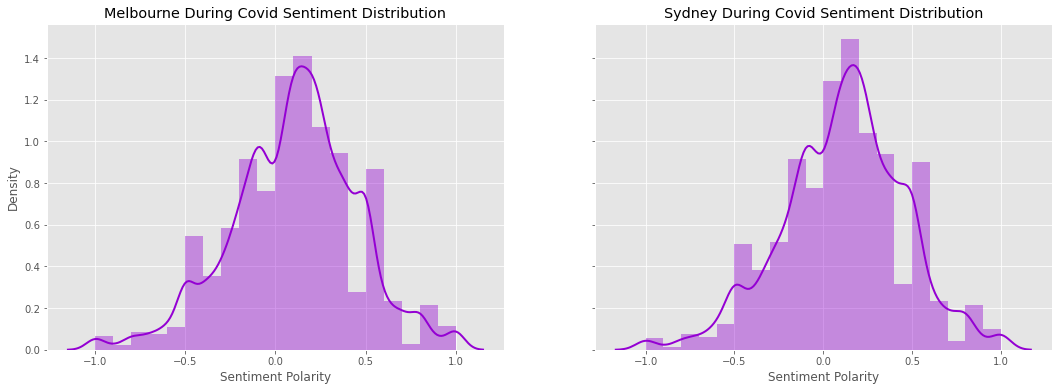

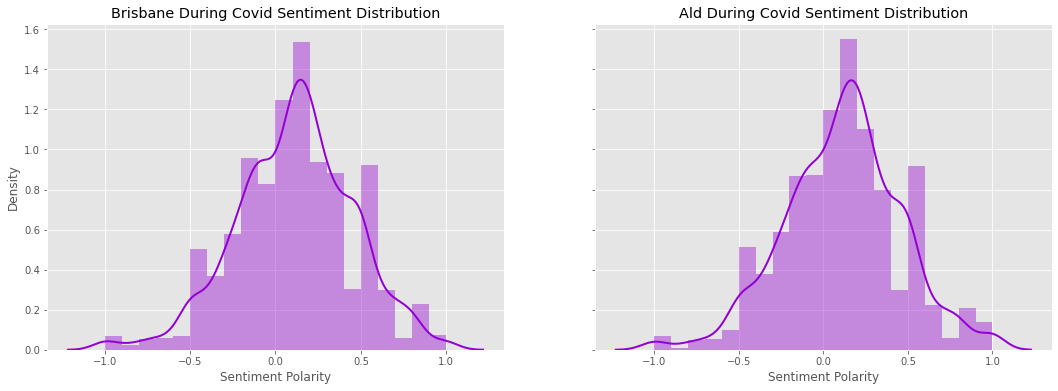

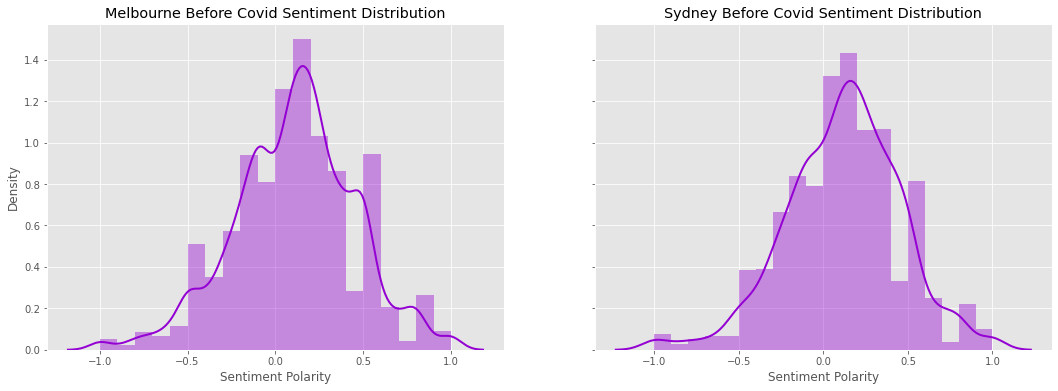

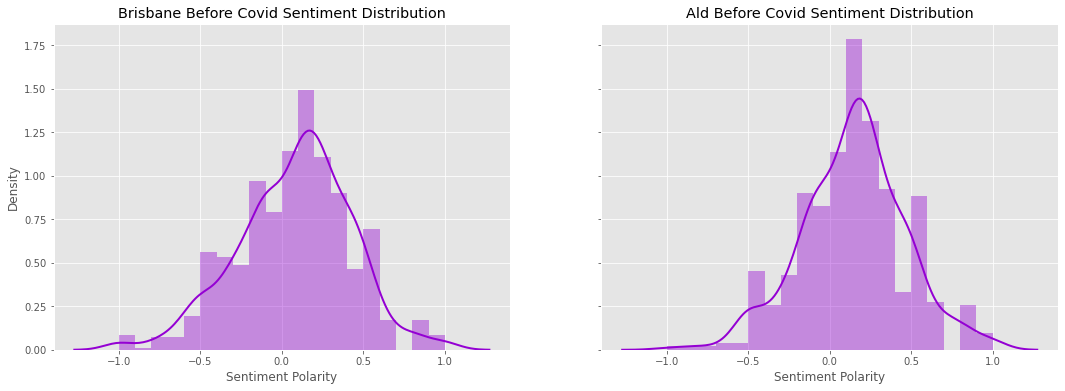

In [217]:
def sentiment_plot(city_1, city_2, title_list):
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), sharey=True)
    n_bins = 20
    sns.distplot(city_1["sentiment_polarity"], ax=ax[0], bins = n_bins, color = "darkviolet", kde_kws = {"linewidth": 2})
    sns.distplot(city_2["sentiment_polarity"], ax=ax[1], bins = n_bins, color = "darkviolet", kde_kws = {"linewidth": 2})
    #sns.distplot(city_3["sentiment_polarity"], ax=ax[2], bins = n_bins, color = "darkviolet", kde_kws = {"linewidth": 2})
    #sns.distplot(city_4["sentiment_polarity"], ax=ax[3], bins = n_bins, color = "darkviolet", kde_kws = {"linewidth": 2})

    for idx, subplot in enumerate(ax):
        #ax.tick_params(axis = "both", labelsize = 14)
        subplot.set_xlabel('Sentiment Polarity')
        subplot.set_ylabel('Density')
        subplot.set_title(title_list[idx])
        #subplot.set_xlabel('Sentiment Polarity')

title_list = ['Melbourne During Covid Sentiment Distribution', 'Sydney During Covid Sentiment Distribution']
sentiment_plot(melbourne_mental, sydney_mental, title_list)

title_list = ['Brisbane During Covid Sentiment Distribution', 'Ald During Covid Sentiment Distribution']
sentiment_plot(brisbane_mental, adelaide_mental, title_list)

title_list = ['Melbourne Before Covid Sentiment Distribution', 'Sydney Before Covid Sentiment Distribution']
sentiment_plot(melbourne_before_mental, sydney_before_mental, title_list)

title_list = ['Brisbane Before Covid Sentiment Distribution', 'Ald Before Covid Sentiment Distribution']
sentiment_plot(brisbane_before_mental, adelaide_before_mental, title_list)

/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

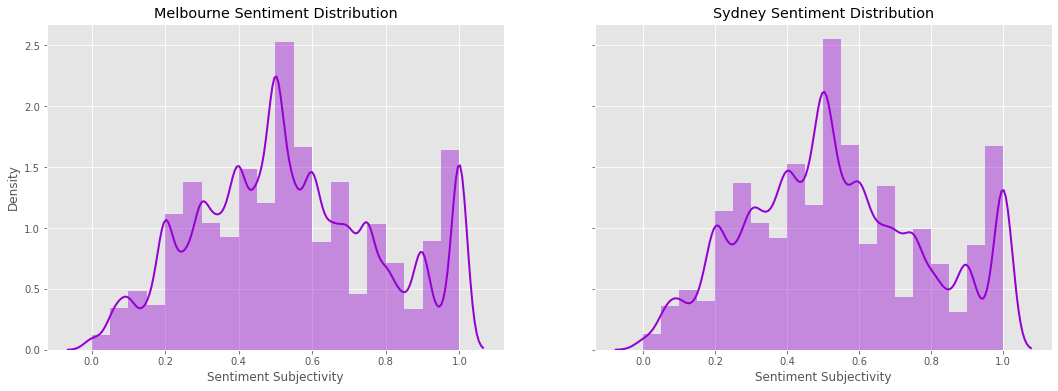

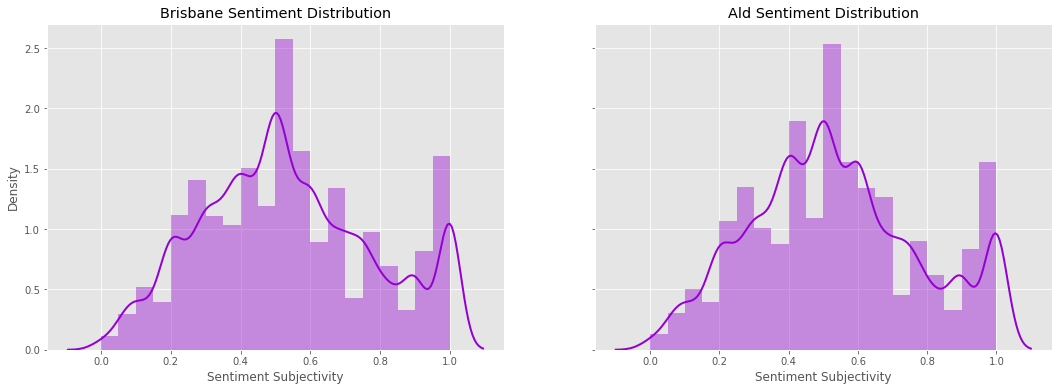

In [179]:
'''
def sentiment_plot(city_1, city_2, title_list):
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), sharey=True)
    n_bins = 20
    sns.distplot(city_1["sentiment_subjectivity"], ax=ax[0], bins = n_bins, color = "darkviolet", kde_kws = {"linewidth": 2})
    sns.distplot(city_2["sentiment_subjectivity"], ax=ax[1], bins = n_bins, color = "darkviolet", kde_kws = {"linewidth": 2})
    #sns.distplot(city_3["sentiment_polarity"], ax=ax[2], bins = n_bins, color = "darkviolet", kde_kws = {"linewidth": 2})
    #sns.distplot(city_4["sentiment_polarity"], ax=ax[3], bins = n_bins, color = "darkviolet", kde_kws = {"linewidth": 2})

    for idx, subplot in enumerate(ax):
        #ax.tick_params(axis = "both", labelsize = 14)
        subplot.set_xlabel('Sentiment Subjectivity')
        subplot.set_ylabel('Density')
        subplot.set_title(title_list[idx])
        #subplot.set_xlabel('Sentiment Polarity')

title_list = ['Melbourne Sentiment Distribution', 'Sydney Sentiment Distribution']#, 'Brisbane Sentiment Distribution', 'Ald Sentiment Distribution']
sentiment_plot(melbourne_mental, sydney_mental, title_list)# brisbane_mental, ald_mental, title_list)

title_list = ['Brisbane Sentiment Distribution', 'Ald Sentiment Distribution']
sentiment_plot(brisbane_mental, adelaide_mental, title_list)
'''

In [219]:
# 判断不同地区mental相关的推文数量，判断是否宜居
print(melbourne_mental.shape)
print(sydney_mental.shape)
print(brisbane_mental.shape)
print(adelaide_mental.shape)
print('\n')
print(melbourne_before_mental.shape)
print(sydney_before_mental.shape)
print(brisbane_before_mental.shape)
print(adelaide_before_mental.shape)

(15484, 8)
(8739, 8)
(2511, 8)
(1980, 8)


(6226, 8)
(1800, 8)
(823, 8)
(510, 8)


In [190]:
melbourne_mental.head()

,id,location,text,time,if_city,cleaned_text,if_mental,sentiment_polarity,sentiment_subjectivity
6065,1519168390942060544,Melbourne,RT @Halalcoholism: In the spirit of free speec...,2022-05,True,RT Halalcoholism In the spirit of free speech ...,True,0.200000,0.45
6091,1516538344649654275,Melbourne,"I must admit, Brad Scott coming out and defend...",2022-05,True,must admit Brad Scott coming out and defending...,True,0.100000,0.20
6100,1515434909719957504,Melbourne,RT @mrpaddygilmore: John Hegarty: “a great ad ...,2022-05,True,RT mrpaddygilmore John Hegarty great ad is pro...,True,0.333333,0.35
6123,1510224303765483524,Melbourne,@maddiemelb This one seemed on the cards. Feel...,2022-05,True,maddiemelb This one seemed on the cards Feels ...,True,0.800000,1.00
6138,1508277915036704774,Melbourne,RT @UberFacts: Someone gets slapped at the Osc...,2022-05,True,RT UberFacts Someone gets slapped at the Oscar...,True,-0.100000,0.40


In [220]:
#import pyecharts.options as opts
#from example.commons import Faker
#from pyecharts.charts import Line

# 处理时间
start = '2020-01'
end = '2022-05'
t = pd.date_range(start=start, end=end, freq = 'M').tolist()
time_frame = []
for i in t:
    i = str(i)[:-12]
    time_frame.append(i)

In [221]:
melbourne_mental_cnt = melbourne_mental.sort_values(['time'], ascending=True).groupby('time')['time'].count()

In [233]:
data_covid = pd.read_csv('NCOV_COVID_Cases_by_LGA_20220511.csv')

In [237]:
time_covid = []

for val in data_covid['diagnosis_date']:
    val = val[0:7]
    time_covid.append(val)

data_covid['time'] = time_covid

In [239]:
data_covid_cnt = data_covid.sort_values(['time'], ascending=True).groupby('time')['time'].count()

<function matplotlib.pyplot.show(close=None, block=None)>

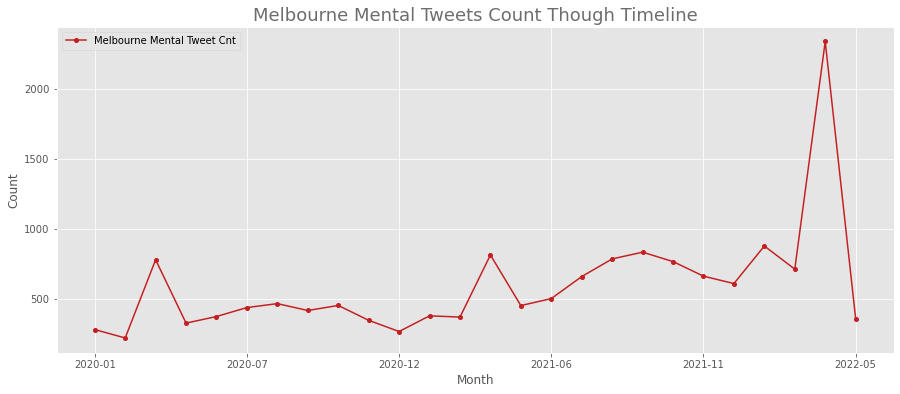

In [255]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(15, 6))
color_1 = '#6D6D6D'

melbourne_mental_cnt.plot(
    color = '#C42022',
    marker = 'o', markersize = 4,
    label = 'Melbourne Mental Tweet Cnt'
)
'''
data_covid_cnt.plot(
    color = '#C42022',
    marker = 'o', markersize = 4,
    label = 'Melbourne Covid Confirmed Cnt'
)
'''

plt.title('Melbourne Mental Tweets Count Though Timeline', color = color_1, fontsize = 18)
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

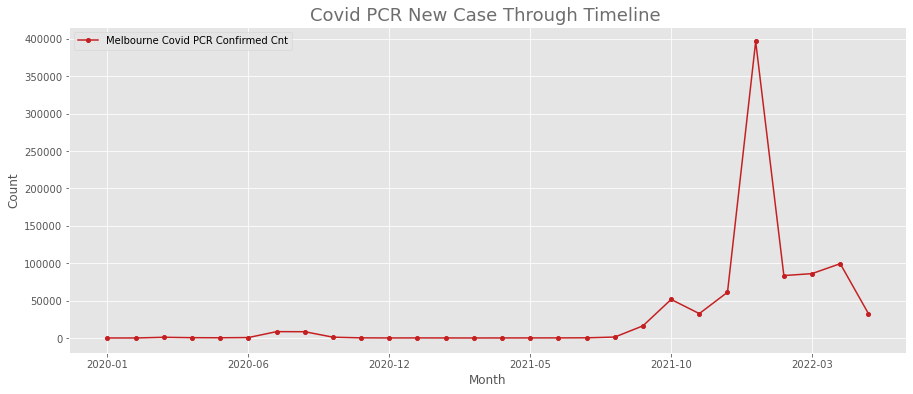

In [257]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(15, 6))
color_1 = '#6D6D6D'
'''
melbourne_mental_cnt.plot(
    color = '#C42022',
    marker = 'o', markersize = 4,
    label = 'Melbourne Mental Tweet Cnt'
)
'''
data_covid_cnt.plot(
    color = '#C42022',
    marker = 'o', markersize = 4,
    label = 'Melbourne Covid PCR Confirmed Cnt'
)


plt.title('Covid PCR New Case Through Timeline ', color = color_1, fontsize = 18)
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend()
plt.show

# Word Cloud

In [230]:
stoplist = ['very', 'ourselves', 'am', 'doesn', 'through', 'me', 'against', 'up', 'just', 'her', 'ours', 
            'couldn', 'because', 'is', 'isn', 'it', 'only', 'in', 'such', 'too', 'mustn', 'under', 'their', 
            'if', 'to', 'my', 'himself', 'after', 'why', 'while', 'can', 'each', 'itself', 'his', 'all', 'once', 
            'herself', 'more', 'our', 'they', 'hasn', 'on', 'ma', 'them', 'its', 'where', 'did', 'll', 'you', 
            'didn', 'nor', 'as', 'now', 'before', 'those', 'yours', 'from', 'who', 'was', 'm', 'been', 'will', 
            'into', 'same', 'how', 'some', 'of', 'out', 'with', 's', 'being', 't', 'mightn', 'she', 'again', 'be', 
            'by', 'shan', 'have', 'yourselves', 'needn', 'and', 'are', 'o', 'these', 'further', 'most', 'yourself', 
            'having', 'aren', 'here', 'he', 'were', 'but', 'this', 'myself', 'own', 'we', 'so', 'i', 'does', 'both', 
            'when', 'between', 'd', 'had', 'the', 'y', 'has', 'down', 'off', 'than', 'haven', 'whom', 'wouldn', 
            'should', 've', 'over', 'themselves', 'few', 'then', 'hadn', 'what', 'until', 'won', 'no', 'about', 
            'any', 'that', 'for', 'shouldn', 'don', 'do', 'there', 'doing', 'an', 'or', 'ain', 'hers', 'wasn', 
            'weren', 'above', 'a', 'at', 'your', 'theirs', 'below', 'other', 'not', 're', 'him', 'during', 'which',
            'im', 'dont', 'havent', 'like', 'one', 'get']

In [231]:
def takeCnt(x):
    return x[1]

def generate_word_list(dataset):
    word_text = [[word for word in doc.lower().split() if word not in stoplist] for doc in dataset['cleaned_text']]
    word_str = ''
    for ele in word_text:
        for val in ele:
            word_str += val + ' '
    
    return word_str


def word_cnt(word_str):

    words = word_str.split()
    word_cnt = {}

    for word in words:
        word_cnt[word] = word_cnt.get(word, 0) + 1

    items = list(word_cnt.items())
    items.sort(key = takeCnt, reverse = True)

    for i in range(10):
        key, value = items[i]
        print('{0:<10}{1:>5}'.format(key, value))

In [232]:
# melbourne 计算词频
print('Melbourne word count: ')
word_cnt(generate_word_list(melbourne_mental))

# sydney 计算词频
print('Sydney word count: ')
word_cnt(generate_word_list(sydney_mental))

# brisbane 计算词频
print('Brisbane word count: ')
word_cnt(generate_word_list(brisbane_mental))

# ald 计算词频
print('Ald word count: ')
word_cnt(generate_word_list(adelaide_mental))

Melbourne word count: 
rt         5996
media       996
people      768
amp         697
new         668
good        533
time        473
health      454
first       451
great       444
Sydney word count: 
rt         4017
amp         700
media       696
new         435
people      427
covid       289
social      276
time        271
event       266
good        265
Brisbane word count: 
rt         1075
media       209
sunstormed  161
people      129
new         104
good         99
morrison     96
amp          88
know         82
day          70
Ald word count: 
rt          830
media       121
people      115
new         102
time         76
amp          74
good         73
today        65
great        64
covid        57


In [188]:
def generate_word_cloud(dataset):
    txt = generate_word_list(dataset)
    font_path = os.environ.get('FONT_PATH', '/Library/Fonts/Times New Roman.ttf')
    w = wordcloud.WordCloud(font_path = font_path, width = 800, height = 600, max_words = 40, font_step = 3)
    w.generate(txt)
    w.to_file('wordcloud.png')

    print('word cloud generated successfully!')

In [189]:
generate_word_cloud(melbourne_mental)

word cloud generated successfully!
